# Visualizations and Numerical Values of the Paper

This notebook contains the code required to reproduce all figures and numerical results presented in the paper.  
For selected visualizations, additional numerical values are reported here for reference, as they were omitted from the paper due to page constraints.

## Imports and Loading Data

In [9]:
# necessary imports
import sys
from pathlib import Path
from dataclasses import dataclass
from typing import Dict, Iterable, List, Optional, Sequence, Tuple, Union

import math
import numpy as np
import pandas as pd
import geopandas as gpd
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, LinearSegmentedColormap

from __future__ import annotations
from shapely.geometry import LineString, Point, MultiLineString
from tueplots import axes, bundles, figsizes
from tueplots import cycler
from tueplots.constants import markers
from tueplots.constants.color import palettes
from tueplots.constants.color import rgb

from PIL import Image
from matplotlib.colors import LogNorm, LinearSegmentedColormap

PROJECT_ROOT = Path.cwd().parent
sys.path.append(str(PROJECT_ROOT))

# module imports
from src.preprocess_data import preprocess_accident_data
from src.routing_graph import (
    GraphBuildConfig,
    RiskConfig,
    RoutingGraphArtifacts,
    build_routing_graph,
    build_graph_with_risk,
    NodeKey,
)
from src.routing_algorithm import (
    route_stats,
    run_one_od_routing,
    path_to_multiline_latlon,
)

DATA_DIR = Path("..") / "data" / "panel"

The next cell loads the data frames that were constructed through the merging procedure executed in `01_data_preparation.ipynb`.

In [10]:
accidents_df = pd.read_csv(DATA_DIR / "berlin_bike_accidents.csv")

segments_df = gpd.read_parquet(DATA_DIR / "segments_with_risk.parquet")
junction_df = gpd.read_parquet(DATA_DIR / "junctions_with_risk.parquet")

counting_vs_strafa_df = pd.read_parquet(
    DATA_DIR / "berlin_counting_stations_strava_comparison.parquet"
)

# one geometry per node_id
crossings_gdf = (
    junction_df[["node_id", "geometry"]]
    .dropna(subset=["node_id", "geometry"])
    .drop_duplicates(subset=["node_id"])
    .copy()
)
crossings_gdf = gpd.GeoDataFrame(crossings_gdf, geometry="geometry", crs=junction_df.crs)

print("segments_df:", segments_df.shape)
print("junction_df:", junction_df.shape)
print("crossings_gdf:", crossings_gdf.shape)
print("accidents_df:", accidents_df.shape)
print("counting_vs_strafa_df:", counting_vs_strafa_df.shape)

segments_df: (260100, 205)
junction_df: (171720, 17)
crossings_gdf: (2862, 2)
accidents_df: (23535, 28)
counting_vs_strafa_df: (32868, 4)


In [11]:
plt.rcParams.update(bundles.icml2024(column="half"))
# TUE colors
plt.rcParams.update({"axes.prop_cycle": plt.cycler(color=palettes.tue_plot)})

The following cell defines global plotting parameters to ensure consistent visual encoding across all network and routing figures.

In [12]:
# Base network 
BASE_LW = 0.22
BASE_ALPHA = 0.10

# Accidents 
ACC_MS = 4.0
ACC_ALPHA = 0.90

# Junctions 
JUNC_MS = 3.5
JUNC_LW = 0.40
JUNC_ALPHA = 0.25

# High-risk segments 
RISK_LW = 1.9
RISK_ALPHA = 0.95

# Routing
ROUTE_LW = 1.6
ROUTE_ALPHA = 0.95

# OD points
OD_S = 30
OD_ALPHA = 1.0


## Figure 1
Visual Abstract Panel

In [13]:
# Plotting year and month filtering only for panel (a)
PLOT_YEAR, PLOT_MONTH = 2021, 6

CENTER_LAT = 52.518589
CENTER_LON = 13.376665
LAT_TOL = 2.4e-2
LON_TOL = 4.8e-2

METRIC_EPSG = 32633


def viewport_bounds(center_lat=CENTER_LAT, center_lon=CENTER_LON, lat_tol=LAT_TOL, lon_tol=LON_TOL):
    x0, x1 = center_lon - lon_tol, center_lon + lon_tol
    y0, y1 = center_lat - lat_tol, center_lat + lat_tol
    return x0, x1, y0, y1


def clip_to_viewport(gdf_ll: gpd.GeoDataFrame) -> gpd.GeoDataFrame:
    x0, x1, y0, y1 = viewport_bounds()
    return gdf_ll.cx[x0:x1, y0:y1]


def apply_center_zoom(ax, center_lat=CENTER_LAT, center_lon=CENTER_LON, lat_tol=LAT_TOL, lon_tol=LON_TOL):
    x0, x1, y0, y1 = viewport_bounds(center_lat, center_lon, lat_tol, lon_tol)
    ax.set_xlim(x0, x1)
    ax.set_ylim(y0, y1)


def _require_crs(gdf: gpd.GeoDataFrame, name: str) -> None:
    if gdf is None or len(gdf) == 0:
        raise ValueError(f"{name} is empty.")
    if gdf.crs is None:
        raise ValueError(f"{name} has no CRS set. Set it upstream (e.g., gdf.set_crs(...)).")


def _to_lonlat(gdf: gpd.GeoDataFrame, name: str) -> gpd.GeoDataFrame:
    _require_crs(gdf, name)
    return gdf.to_crs("EPSG:4326")


# Deduplicate geometries for plotting (avoid alpha stacking)
def dedupe_geometries(gdf: gpd.GeoDataFrame) -> gpd.GeoDataFrame:
    if gdf is None or len(gdf) == 0:
        return gdf
    return (
        gdf.assign(_wkt=gdf.geometry.to_wkt())
           .drop_duplicates("_wkt")
           .drop(columns="_wkt")
    )


# Panel (a): accidents on network
def plot_panel_a(ax, segments_ll: gpd.GeoDataFrame, accidents_df: pd.DataFrame):
    accidents_gdf = gpd.GeoDataFrame(
        accidents_df,
        geometry=gpd.points_from_xy(accidents_df["XGCSWGS84"], accidents_df["YGCSWGS84"]),
        crs="EPSG:4326",
    )

    # Filter accidents by month for readability
    accidents_m = accidents_gdf.query("year == @PLOT_YEAR and month == @PLOT_MONTH")

    # Avoid alpha stacking from duplicated geometries
    segments_plot = dedupe_geometries(segments_ll)

    segments_plot.plot(
        ax=ax,
        color=rgb.tue_dark,
        linewidth=BASE_LW,
        alpha=BASE_ALPHA,
        zorder=1,
    )

    accidents_m.plot(
        ax=ax,
        color=rgb.tue_orange,
        markersize=ACC_MS,
        alpha=ACC_ALPHA,
        zorder=3,
    )

    apply_center_zoom(ax)
    ax.axis("off")


# Panel (b): risk + junction context
def plot_panel_b(ax, segments_ll: gpd.GeoDataFrame, junctions_ll: gpd.GeoDataFrame, *, seg_risk_col="risk_weight"):
    if seg_risk_col not in segments_ll.columns:
        raise ValueError(f"Missing segment risk column '{seg_risk_col}' in segments GeoDataFrame")

    x0, x1, y0, y1 = viewport_bounds()

    # Avoid alpha stacking from duplicated geometries
    segments_plot = dedupe_geometries(segments_ll)
    junctions_plot = dedupe_geometries(junctions_ll)

    segments_plot.plot(
        ax=ax,
        color=rgb.tue_dark,
        linewidth=BASE_LW,
        alpha=BASE_ALPHA,
        zorder=1,
    )

    s = pd.to_numeric(segments_plot[seg_risk_col], errors="coerce")
    q = float(np.nanquantile(s, 0.90))
    high_risk = segments_plot.loc[s >= q]
    high_risk.plot(
        ax=ax,
        color=rgb.tue_red,
        linewidth=RISK_LW,
        alpha=RISK_ALPHA,
        zorder=3,
    )

    j_ctx = junctions_plot.cx[x0:x1, y0:y1]
    if "degree" in j_ctx.columns:
        j_ctx = j_ctx.query("degree >= 3")

    j_ctx.plot(
        ax=ax,
        markersize=JUNC_MS,
        facecolors="none",
        edgecolors=rgb.tue_dark,
        linewidths=JUNC_LW,
        alpha=JUNC_ALPHA,
        zorder=2,
    )

    ax.set_xlim(x0, x1)
    ax.set_ylim(y0, y1)
    ax.axis("off")


# Panel (c): routing paths
def plot_panel_c(
    ax,
    *,
    segments_ll: gpd.GeoDataFrame,
    junctions_ll: gpd.GeoDataFrame,
    segments_df: gpd.GeoDataFrame,
    junction_df: gpd.GeoDataFrame,
    crossings_gdf: gpd.GeoDataFrame,
    eps=0.10,
    eta=1.0,
    rng_seed=12345,
    graph_artifacts=None,
):
    x0, x1, y0, y1 = viewport_bounds()

    # Avoid alpha stacking from duplicated geometries
    segments_plot = dedupe_geometries(segments_ll)
    junctions_plot = dedupe_geometries(junctions_ll)

    # OD candidates are chosen from pooled junctions in lon/lat
    rng = np.random.default_rng(rng_seed)
    candidates = junctions_plot.cx[x0:x1, y0:y1].copy()
    if "degree" in candidates.columns:
        candidates = candidates.query("degree >= 3")

    if len(candidates) < 2:
        raise ValueError(
            f"Not enough junction candidates inside the fixed window. Found {len(candidates)}. "
        )

    coords = np.column_stack([candidates.geometry.x.to_numpy(), candidates.geometry.y.to_numpy()])  # lon, lat
    i, j = rng.choice(len(coords), size=2, replace=False)
    origin_lonlat = (float(coords[i, 0]), float(coords[i, 1]))
    dest_lonlat = (float(coords[j, 0]), float(coords[j, 1]))
    ox, oy = origin_lonlat
    dx, dy = dest_lonlat

    # Build graph once
    if graph_artifacts is None:
        graph_artifacts = build_graph_with_risk(
            segments_panel_gdf=segments_df,
            crossings_gdf=crossings_gdf,
            junction_panel_gdf=junction_df,
            risk_cfg=RiskConfig(eta=eta),
        )
    G = graph_artifacts.G

    # Run routing
    result = run_one_od_routing(
        segments_panel_gdf=segments_df,
        crossings_gdf=crossings_gdf,
        junction_panel_gdf=junction_df,
        origin_lonlat=origin_lonlat,
        dest_lonlat=dest_lonlat,
        eps=eps,
        eta=eta,
        metric_epsg=METRIC_EPSG,
    )

    if result.get("status") == "disconnected":
        shortest_geom = None
        safe_geom = None
    else:
        shortest_geom = path_to_multiline_latlon(
            G, result["shortest_length_path"], metric_epsg=METRIC_EPSG, choose_by="length_m"
        )
        safe_geom = path_to_multiline_latlon(
            G, result["constrained_min_risk_path"], metric_epsg=METRIC_EPSG, choose_by="risk_total"
        )

    # Base network
    segments_plot.plot(
        ax=ax,
        color=rgb.tue_dark,
        linewidth=BASE_LW,
        alpha=BASE_ALPHA,
        zorder=1,
    )

    # Junction context
    j_ctx = junctions_plot.cx[x0:x1, y0:y1]
    if "degree" in j_ctx.columns:
        j_ctx = j_ctx.query("degree >= 3")
    j_ctx.plot(
        ax=ax,
        markersize=JUNC_MS,
        facecolors="none",
        edgecolors=rgb.tue_dark,
        linewidths=JUNC_LW,
        alpha=JUNC_ALPHA,
        zorder=2,
    )

    # Routes
    if shortest_geom is not None:
        gpd.GeoSeries([shortest_geom], crs="EPSG:4326").plot(
            ax=ax,
            color=rgb.tue_blue,
            linewidth=ROUTE_LW,
            alpha=ROUTE_ALPHA,
            zorder=4,
        )

    if safe_geom is not None:
        gpd.GeoSeries([safe_geom], crs="EPSG:4326").plot(
            ax=ax,
            color=rgb.tue_green,
            linewidth=ROUTE_LW,
            alpha=ROUTE_ALPHA,
            zorder=5,
        )

    # Origin / destination markers
    ax.scatter([ox], [oy], s=16, marker="o", color=rgb.tue_ocre, zorder=7)
    ax.scatter([dx], [dy], s=24, marker="x", color=rgb.tue_ocre, linewidths=1.2, zorder=7)

    ax.set_xlim(x0, x1)
    ax.set_ylim(y0, y1)
    ax.axis("off")

    return result, G, shortest_geom, safe_geom, (ox, oy, dx, dy)


def make_three_panel_figure(
    *,
    segments_df: gpd.GeoDataFrame,
    junction_df: gpd.GeoDataFrame,
    accidents_df: pd.DataFrame,
    crossings_gdf: gpd.GeoDataFrame,
    eps=0.10,
    eta=1.0,
    outpath="../report/figs/map_3panel.pdf",
):
    # Convert plotting layers to lon/lat for consistent viewport slicing
    segments_ll = _to_lonlat(segments_df, "segments_df")
    junctions_ll = _to_lonlat(junction_df, "junction_df")

    # Clip to viewport to keep PDF size manageable
    segments_ll = clip_to_viewport(segments_ll)
    junctions_ll = clip_to_viewport(junctions_ll)

    # Build pooled graph artifacts once (used in panel c)
    graph_artifacts = build_graph_with_risk(
        segments_panel_gdf=segments_df,
        crossings_gdf=crossings_gdf,
        junction_panel_gdf=junction_df,
        risk_cfg=RiskConfig(eta=eta),
    )

    with plt.rc_context(bundles.icml2024(column="full", nrows=1, ncols=3)):
        fig, axs = plt.subplots(1, 3)

        plot_panel_a(axs[0], segments_ll, accidents_df)
        plot_panel_b(axs[1], segments_ll, junctions_ll, seg_risk_col="risk_weight")

        routing_result = plot_panel_c(
            axs[2],
            segments_ll=segments_ll,
            junctions_ll=junctions_ll,
            segments_df=segments_df,
            junction_df=junction_df,
            crossings_gdf=crossings_gdf,
            eps=eps,
            eta=eta,
            graph_artifacts=graph_artifacts,
        )

        labels = ["(a) Data", "(b) Risk estimation", "(c) Safety routing"]
        for ax, lab in zip(axs, labels):
            ax.text(0.5, -0.06, lab, transform=ax.transAxes, ha="center", va="top")

        fig.savefig(outpath)
        return fig, axs, routing_result


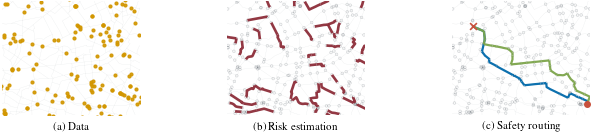

In [14]:
fig, axs, (result_from_fig, G_from_fig, shortest_geom_from_fig, safe_geom_from_fig, od_coords) = make_three_panel_figure(
    segments_df=segments_df,
    junction_df=junction_df,
    accidents_df=accidents_df,
    crossings_gdf=crossings_gdf,
    eps=0.10,
    eta=1.0,
    outpath="../report/figs/map_3_panels.pdf",
)
plt.show()


### Numerical Values (omitted from the paper)

The next cell uses the routing results computed in the previous cell and unpacks the results from the `make_three_panel_figure` function.

In [15]:
result_berlin = result_from_fig
G = G_from_fig
shortest_geom = shortest_geom_from_fig
safe_geom = safe_geom_from_fig
ox, oy, dx, dy = od_coords


The next cell computes the route statistics.

In [16]:
# Check route lengths + detour constraint
p_len = result_berlin["shortest_length_path"]
p_safe = result_berlin["constrained_min_risk_path"]

paths_identical = (p_len == p_safe)
print("Paths identical:", paths_identical)

# Choose-by for MultiGraph edge selection:
st_len  = route_stats(G, p_len,  choose_by="length_m")
st_safe = route_stats(G, p_safe, choose_by="risk_total")

shortest_length = float(st_len["length_m"])
safe_length     = float(st_safe["length_m"])

print(f"Shortest path length: {shortest_length:.1f} m")
print(f"Safe route length:    {safe_length:.1f} m")

# Report route risk 
print(f"Shortest route risk_total: {float(st_len['risk_total_sum']):.3f}")
print(f"Safe route risk_total:     {float(st_safe['risk_total_sum']):.3f}")

# Check detour constraint
eps = result_berlin.get("params", {}).get("eps", result_berlin.get("eps", 0.10))
max_allowed = (1.0 + float(eps)) * shortest_length
detour_pct = ((safe_length / shortest_length) - 1.0) * 100.0 if shortest_length > 0 else float("nan")

print(f"Detour: {detour_pct:.2f}%")
print(f"Max allowed length: {max_allowed:.1f} m")

if safe_length <= max_allowed + 1e-6:
    print("Constraint satisfied.")
else:
    print("WARNING: Constraint violated (check routing selection / edge-choice consistency).")

# Report deltas from result_berlin for cross-check
if "delta_L" in result_berlin and result_berlin["delta_L"] is not None:
    print(f"delta_L: {100*result_berlin['delta_L']:.2f}%")
if "delta_R" in result_berlin and result_berlin["delta_R"] is not None:
    print(f"delta_R: {100*result_berlin['delta_R']:.2f}%")


Paths identical: False
Shortest path length: 7911.0 m
Safe route length:    8463.2 m
Shortest route risk_total: 0.005
Safe route risk_total:     0.003
Detour: 6.98%
Max allowed length: 8702.1 m
Constraint satisfied.
delta_L: 6.98%
delta_R: 39.82%


## Figure 2
Counting Data Consistancy Check

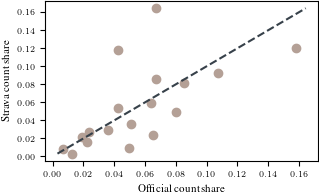

In [17]:
# Year 2023: segment share scatter (official vs Strava)
counting_vs_strafa_df["date"] = pd.to_datetime(counting_vs_strafa_df["date"], errors="coerce")
counting_vs_strafa_df[["total_count", "strata_count"]] = counting_vs_strafa_df[["total_count", "strata_count"]].apply(
    pd.to_numeric, errors="coerce"
)

df = counting_vs_strafa_df[counting_vs_strafa_df["date"].dt.year == 2023].dropna(subset=["segment", "total_count", "strata_count"])

yearly = (
    df.groupby("segment", as_index=False)[["total_count", "strata_count"]]
    .sum()
)
yearly["official_share"] = yearly["total_count"] / yearly["total_count"].sum()
yearly["strava_share"] = yearly["strata_count"] / yearly["strata_count"].sum()

# plot
fig, ax = plt.subplots()

ax.scatter(
    yearly["official_share"],
    yearly["strava_share"],
    color=rgb.tue_mauve
)

# 45-degree reference line
minv = min(yearly["official_share"].min(), yearly["strava_share"].min())
maxv = max(yearly["official_share"].max(), yearly["strava_share"].max())
ax.plot(
    [minv, maxv],
    [minv, maxv],
    linestyle="--",
    color=rgb.tue_dark
)

ax.set_xlabel("Official count share")
ax.set_ylabel("Strava count share")

fig.savefig("../report/figs/segment_share.pdf")
plt.show()

## Figure 3 (omitted)

### Create a first heatmap

In [18]:
# Filter and Aggregate segments dataframe
import geopandas as gpd; import matplotlib.pyplot as plt
segments_with_risk = gpd.read_parquet("../data/panel/segments_with_risk.parquet")
segments_with_risk = segments_with_risk.loc[:, ["counter_name", "year", "month", "geometry", "latitude", "longitude",
                                                "total_accidents", "sum_strava_total_trip_count", "street_name", "rr_secure"]]
original_crs = segments_with_risk.crs
agg_logic = {
    'total_accidents': 'sum',
    'sum_strava_total_trip_count': 'sum',
    'geometry': 'first',
    'latitude': 'first',
    'longitude': 'first',
    'street_name': 'first',
    'rr_secure': 'first'
}
agg_segments = segments_with_risk.groupby('counter_name').agg(agg_logic).reset_index()
agg_segments = gpd.GeoDataFrame(agg_segments, geometry='geometry', crs=original_crs)

In [19]:
# Filter and Aggregate junctions dataframe
junctions_with_risk = gpd.read_parquet(path="../data/panel/junctions_with_risk.parquet")
original_crs = junctions_with_risk.crs
agg_logic = {
    'total_accidents': 'sum',
    'monthly_strava_trips': 'sum',
    'geometry': 'first',
    'rr_secure': 'first'
}
agg_junctions = junctions_with_risk.groupby('node_id').agg(agg_logic).reset_index()
agg_junctions = gpd.GeoDataFrame(agg_junctions, geometry='geometry', crs=original_crs)

In [20]:
# functioin for zooming into the map
def viewport_bounds(center_lat, center_lon, lat_tol, lon_tol):
    x0, x1 = center_lon - lon_tol, center_lon + lon_tol
    y0, y1 = center_lat - lat_tol, center_lat + lat_tol
    return x0, x1, y0, y1


def apply_center_zoom(ax, center_lat, center_lon, lat_tol, lon_tol):
    x0, x1, y0, y1 = viewport_bounds(center_lat, center_lon, lat_tol, lon_tol)
    ax.set_xlim(x0, x1)
    ax.set_ylim(y0, y1)


# using tübingen colors
diverging_colors = [rgb.tue_blue, rgb.tue_lightblue, rgb.tue_gray, rgb.pn_orange, rgb.tue_red]

tue_map = LinearSegmentedColormap.from_list("tue_blue_red", diverging_colors, N=256)

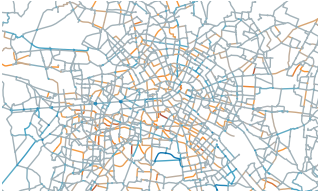

In [21]:
def plot_segment_risk(
    segment_df,
    junction_df,
    center_lat,
    center_lon,
    lat_tol,
    lon_tol,
    risk_column: str = "risk_estimate",
    output_path: str | None = None,
):
    plt.rcParams.update(figsizes.icml2024_half())
    fig, ax = plt.subplots()
     
    risk_segments = segment_df[risk_column]
    risk_junctions = junction_df[risk_column]

    risk_all = np.concatenate([
        risk_segments[risk_segments > 0].to_numpy(),
        risk_junctions[risk_junctions > 0].to_numpy(),
    ])

    # set range for colorbar normalization
    vmin = risk_all.min()
    vmax = risk_all.max()

    norm = LogNorm(vmin=vmin, vmax=vmax)

    segment_df.plot(
        ax=ax,
        column=risk_column,
        cmap=tue_map,
        linewidth=1,
        legend=False,
        norm=norm,
        zorder=1
    )

    junction_df.plot(     
        ax=ax,
        column=risk_column,
        cmap=tue_map,
        linewidth=0.8,
        norm=norm,
        markersize=0.4,
        zorder=2 # plot junctions on top
    )

    # Hide axes
    ax.set_axis_off()

    # zooming into center to improve readability
    apply_center_zoom(ax=ax, center_lat=center_lat, center_lon=center_lon, lat_tol=lat_tol, lon_tol=lon_tol)

    if output_path:
        plt.savefig(output_path)
    plt.show()


plot_segment_risk(
    segment_df=agg_segments,
    junction_df=agg_junctions,
    center_lat = 5820000,
    center_lon = 391000,
    lat_tol = 1.2*6000,
    lon_tol = 2.0*6000,
    risk_column="rr_secure",
    output_path="../report/figs/risk_segments.pdf",
)


## Figure 4
Panel with zoom into Junction 2482

### Inspect selected Junction

In [22]:
center_lat = 52.5742893033972 
center_lon = 13.38955712127424
acc_lat_tol = 0.0002246
acc_lon_tol = 0.0003683
min_lat, max_lat = center_lat - acc_lat_tol, center_lat + acc_lat_tol
min_lon, max_lon = center_lon - acc_lon_tol, center_lon + acc_lon_tol


selcted_accs = accidents_df[accidents_df["YGCSWGS84"].between(min_lat, max_lat) & accidents_df["XGCSWGS84"].between(min_lon, max_lon)]
selcted_accs.head()

,object_id,land_code,admin_region_code,district_code,municipality_code,year,month,hour,weekday,injury_severity,...,involved_other_vehicle,LINREFX,LINREFY,XGCSWGS84,YGCSWGS84,road_condition_flag,source_file,accident_id_extended,oid,plausibility_level
637,191227.0,11,0,3,3,2019,1,17,2,3,...,0,797412.634057,5.833971e+06,13.389773,52.574292,1,Unfallorte2019_LinRef.csv,,NaN,NaN
1069,192841.0,11,0,3,3,2019,3,19,3,2,...,0,797412.357101,5.833971e+06,13.389769,52.574293,0,Unfallorte2019_LinRef.csv,,NaN,NaN
1472,193949.0,11,0,3,3,2019,4,18,2,3,...,0,797412.910936,5.833971e+06,13.389777,52.574290,0,Unfallorte2019_LinRef.csv,,NaN,NaN
1569,194165.0,11,0,3,3,2019,4,20,6,3,...,0,797413.378946,5.833971e+06,13.389783,52.574288,0,Unfallorte2019_LinRef.csv,,NaN,NaN
1917,194986.0,11,0,3,3,2019,5,17,3,3,...,0,797412.634057,5.833971e+06,13.389773,52.574292,0,Unfallorte2019_LinRef.csv,,NaN,NaN


Findings:
- all with second vehicle involved!
	- 20 with cars
	- 1 with goods truck
	- 1 with other vehicle
- accident types: 
	2 = Accident caused by turning off the road (2)
	3 = Accident caused by turning into a road or by
crossing into a road (20)
- 2020 only 1 accident, all other years 5 or 6 accidents reported (no information about construction work found for 2020
--> this supports our assumption that the cars crossing a bicycle lane could be the problem here

work_hours (7h-18h) 55%
evening (18h-22h) 32%
night (22h-7h) 14%

### Create Folium Map

This folium map is required to achieve a visualization with street names and to provide an interactive example.

In [23]:
def plot_rr_map(
    segments_df,
    junction_df,
    *,
    show="both",  # "both" | "segments" | "junctions"
    metric="raw_rr",  # "raw_rr" | any column name
    seg_metric_col=None,
    jn_metric_col=None,
    coordinates=None,
    segment_weight=20,
    junction_radius=15,
    use_log_scale=True,  # New parameter to match plot_segment_risk behavior
    colormap_colors=None,  # New parameter for custom colormap
):
    """Create interactive Folium map of segments (lines) and junctions (circles) colored by metric. Supports flexible show/metric options."""
    import geopandas as gpd
    import numpy as np
    import folium
    from branca import colormap as cm
    from matplotlib.colors import to_hex
    try:
        from matplotlib import pyplot as plt
    except ImportError:
        plt = None

    def _ensure_geo(gdf, geometry_col="geometry"):
        if not isinstance(gdf, gpd.GeoDataFrame):
            gdf = gpd.GeoDataFrame(gdf, geometry=geometry_col)
        if geometry_col in gdf.columns:
            gdf = gdf.set_geometry(geometry_col)
        return gdf

    def _aggregate(df, id_col, extra_cols=()):
        agg_spec = dict(
            geometry=("geometry", "first"),
            total_accidents=("total_accidents", "sum"),
        )

        if "sum_strava_total_trip_count" in df.columns:
            agg_spec["exposure"] = ("sum_strava_total_trip_count", "sum")
        elif "monthly_strava_trips" in df.columns:
            agg_spec["exposure"] = ("monthly_strava_trips", "sum")
        elif "exposure" in df.columns:
            agg_spec["exposure"] = ("exposure", "sum")

        for c in extra_cols:
            if c and c in df.columns:
                agg_spec[c] = (c, "first")
        out = df.groupby(id_col, as_index=False).agg(**agg_spec)
        return gpd.GeoDataFrame(out, geometry="geometry", crs=df.crs)

    def _resolve_metric(df, kind, metric_name, metric_col):
        if metric_col is not None:
            if metric_col not in df.columns:
                raise KeyError(f"{kind}: metric column {metric_col!r} not in dataframe")
            return metric_col

        if metric_name == "raw_rr" and "raw_rr" not in df.columns:
            raise KeyError(
                f"{kind}: metric 'raw_rr' not found. "
                f"Pass seg_metric_col/jn_metric_col or compute it before plotting."
            )

        if metric_name not in df.columns:
            raise KeyError(
                f"{kind}: metric {metric_name!r} not found. "
                f"Pass seg_metric_col/jn_metric_col or ensure it exists before aggregation."
            )
        return metric_name

    if show not in {"both", "segments", "junctions"}:
        raise ValueError("show must be one of: 'both', 'segments', 'junctions'")

    segments_df = _ensure_geo(segments_df)
    junction_df = _ensure_geo(junction_df)

    seg = _aggregate(segments_df, "counter_name", extra_cols=[metric, seg_metric_col]) if show in {"both", "segments"} else None
    jn = _aggregate(junction_df, "node_id", extra_cols=[metric, jn_metric_col]) if show in {"both", "junctions"} else None

    seg_metric = None
    if seg is not None:
        seg_metric = _resolve_metric(seg, "segments", metric, seg_metric_col)
        seg[seg_metric] = seg[seg_metric].replace([np.inf, -np.inf], np.nan).fillna(0.0)

    jn_metric = None
    if jn is not None:
        jn_metric = _resolve_metric(jn, "junctions", metric, jn_metric_col)
        jn[jn_metric] = jn[jn_metric].replace([np.inf, -np.inf], np.nan).fillna(0.0)

    # Collect positive values for range calculation (matching plot_segment_risk)
    vals = []
    if seg is not None:
        vals.append(seg.loc[seg[seg_metric] > 0, seg_metric].to_numpy())
    if jn is not None:
        vals.append(jn.loc[jn[jn_metric] > 0, jn_metric].to_numpy())
    all_pos = np.concatenate([v for v in vals if v.size]) if vals else np.array([])

    if all_pos.size == 0:
        vmin, vmax = 0.1, 1.0
    else:
        vmin = float(all_pos.min())
        vmax = float(all_pos.max())
    
    # Ensure vmin is positive for log scale
    if vmin <= 0:
        vmin = 0.01

    if seg is not None:
        seg["_metric"] = seg[seg_metric].clip(lower=vmin)
        if use_log_scale:
            seg["_log_rr"] = np.log10(seg["_metric"])
        else:
            seg["_log_rr"] = seg["_metric"]
        seg_wgs = seg.to_crs(epsg=4326)
    else:
        seg_wgs = None

    if jn is not None:
        jn["_metric"] = jn[jn_metric].clip(lower=vmin)
        if use_log_scale:
            jn["_log_rr"] = np.log10(jn["_metric"])
        else:
            jn["_log_rr"] = jn["_metric"]
        jn_wgs = jn.to_crs(epsg=4326)
    else:
        jn_wgs = None


    colors = colormap_colors

    if use_log_scale:
        log_vmin = np.log10(vmin)
        log_vmax = np.log10(vmax)
        cmap = cm.LinearColormap(
            colors=colors,
            vmin=log_vmin,
            vmax=log_vmax,
        )
        cmap.caption = f"log10({seg_metric or jn_metric or metric})"
    else:
        cmap = cm.LinearColormap(
            colors=colors,
            vmin=vmin,
            vmax=vmax,
        )
        cmap.caption = f"{seg_metric or jn_metric or metric}"

    m = folium.Map(location=(52.5742893033972, 13.38955712127424), zoom_start=17, tiles="CartoDB Positron", max_zoom=100)

    if seg_wgs is not None and len(seg_wgs):
        seg_fields = ["counter_name", seg_metric]
        seg_aliases = ["Segment", seg_metric]
        if "exposure" in seg_wgs.columns:
            seg_fields.append("exposure")
            seg_aliases.append("Exposure")
        if "total_accidents" in seg_wgs.columns:
            seg_fields.append("total_accidents")
            seg_aliases.append("Accidents")

        def _seg_style(feat):
            lr = float(feat["properties"]["_log_rr"])
            return {"color": cmap(lr), "weight": segment_weight, "opacity": 0.85}

        folium.GeoJson(
            seg_wgs[seg_fields + ["_log_rr", "geometry"]],
            name=f"Segments ({seg_metric})",
            style_function=_seg_style,
            tooltip=folium.GeoJsonTooltip(
                fields=seg_fields,
                aliases=seg_aliases,
                localize=True,
            ),
        ).add_to(m)

    if jn_wgs is not None and len(jn_wgs):
        for _, r in jn_wgs.iterrows():
            if r.geometry is None or not np.isfinite(r.geometry.x) or not np.isfinite(r.geometry.y):
                continue
            lr = float(r["_log_rr"])
            exposure_txt = f" | exposure={float(r['exposure']):.0f}" if "exposure" in jn_wgs.columns else ""
            accidents_txt = (
                f" | accidents={int(r['total_accidents'])}"
                if "total_accidents" in jn_wgs.columns and np.isfinite(r["total_accidents"])
                else ""
            )
            folium.CircleMarker(
                location=[r.geometry.y, r.geometry.x],
                radius=junction_radius,
                color=cmap(lr),
                fill=True,
                fill_color=cmap(lr),
                fill_opacity=1.0,
                weight=5,
                tooltip=(
                    f"node_id={int(r.node_id)} | {jn_metric}={float(r[jn_metric]):.2f}"
                    f"{exposure_txt}{accidents_txt}"
                ),
            ).add_to(m)

    cmap.add_to(m)
    folium.LayerControl(collapsed=False).add_to(m)
    return m

In [24]:
# Extract colors from tue_map
from matplotlib.colors import to_hex
n_colors = 256
tue_colors = [to_hex(tue_map(i / n_colors)) for i in range(n_colors)]

m = plot_rr_map(
    segments_df=agg_segments,
    junction_df=agg_junctions,
    metric="rr_secure",
    colormap_colors=tue_colors
)
import folium
#accidents_df["XGCSWGS84"], accidents_df["YGCSWGS84"])
for _, r in selcted_accs.iterrows():
    folium.CircleMarker(
        location=[r["YGCSWGS84"], r["XGCSWGS84"]],
        color = "black",
        fill_color="black",
        fill_opacity=0.9,
        fill=True,
        weight=1,
        radius=3,
    ).add_to(m)

In [25]:
m.save("../report/figs/risk_map2.html")

### Generating Panel used as Figure 3 in the Report

In [26]:
def plot_panel_a_risk(
    ax,
    segment_df,
    junction_df,
    risk_column,
    center_lat=52.518589,
    center_lon=13.376665,
    lat_tol=0.024,
    lon_tol=0.048,
):
    """Panel (a): Overall risk heatmap"""

    risk_segments = segment_df[risk_column]
    risk_junctions = junction_df[risk_column]

    risk_all = np.concatenate([
        risk_segments[risk_segments > 0].to_numpy(),
        risk_junctions[risk_junctions > 0].to_numpy(),
    ])

    vmin = risk_all.min()
    vmax = risk_all.max()
    norm = LogNorm(vmin=vmin, vmax=vmax)

    segment_df.plot(
        ax=ax,
        column=risk_column,
        cmap=tue_map,
        linewidth=1,
        legend=False,
        norm=norm,
        zorder=1,
    )

    junction_df.plot(
        ax=ax,
        column=risk_column,
        cmap=tue_map,
        linewidth=0.8,
        norm=norm,
        markersize=0.4,
        zorder=2,
    )

    ax.set_axis_off()

    apply_center_zoom(
        ax=ax,
        center_lat=center_lat,
        center_lon=center_lon,
        lat_tol=lat_tol * 1,
        lon_tol=lon_tol * 2.18,
    )


def plot_panel_b_image(ax, image_path):
    """Panel (c): Display PNG image at high resolution"""
    img = Image.open(image_path)  
    ax.imshow(img, interpolation='bilinear')
    ax.set_axis_off()


def plot_panel_c_image(ax, image_path):
    """Panel (c): Display JPEG image at high resolution"""
    img = Image.open(image_path)
    ax.imshow(img, interpolation='bilinear')
    ax.set_axis_off()


def make_three_panel_figure_risk(
    *,
    segment_df: gpd.GeoDataFrame,
    junction_df: gpd.GeoDataFrame,
    image_path_b: str = "../report/figs/high_risk_junction.png",
    image_path_c: str = "../report/figs/Streetview.jpeg",
    risk_column: str = "rr_secure",
    center_lat: float = 52.5742893033972,  
    center_lon: float = 13.38955712127424,  
    lat_tol: float = 0.04,  
    lon_tol: float = 0.04,  
    outpath: str = "../report/figs/risk_3_panel.pdf",
):
    with plt.rc_context(bundles.icml2024(column="full", nrows=1, ncols=3)):
        fig, axs = plt.subplots(1, 3)
        
        # Panel (a): Overall risk map
        plot_panel_a_risk(axs[0], segment_df, junction_df, risk_column,
                         center_lat, center_lon, lat_tol, lon_tol)
        
        # Panel (b): PNG image
        plot_panel_b_image(axs[1], image_path_b)
        
        # Panel (c): JPEG image
        plot_panel_c_image(axs[2], image_path_c)
        
        labels = ["(a) Risk heatmap", "(b) High-risk junction", "(c) Street-level view"]
        for ax, lab in zip(axs, labels):
            ax.text(0.5, -0.06, lab, transform=ax.transAxes, ha="center", va="top")
        
        fig.savefig(outpath, dpi=300) # specify dpi for high-res images
        plt.show()
        return fig, axs

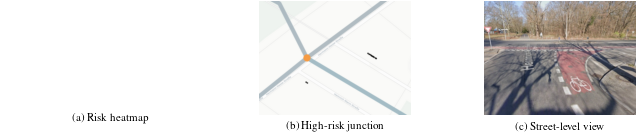

In [27]:
fig, axs = make_three_panel_figure_risk(
    segment_df=agg_segments,
    junction_df=agg_junctions
)

## Numbers for Results section (Risk Estimates)

In [28]:
rr_segments_df = pd.read_parquet(DATA_DIR / "segments_with_risk.parquet")
rr_junctions_df = pd.read_parquet(DATA_DIR / "junctions_with_risk.parquet")

In [29]:
print("risk for junction 2482: " + str(rr_junctions_df.loc[rr_junctions_df["node_id"] == 2482, "rr_secure"].iloc[0]))

risk for junction 2482: 6.402401887438277


In [30]:
# count segments and junctions with risk > 1 and <1 and ==1 respectively
print("high-risk segments:", (rr_segments_df["rr_secure"] > 1).sum() / len(rr_segments_df) * 100)
print("low-risk segments:", (rr_segments_df["rr_secure"] < 1).sum() / len(rr_segments_df) * 100)
print("neutral-risk segments:", (rr_segments_df["rr_secure"] == 1).sum() / len(rr_segments_df) * 100)

print("high-risk junctions:", (rr_junctions_df["rr_secure"] > 1).sum() / len(rr_junctions_df) * 100)
print("low-risk junctions:", (rr_junctions_df["rr_secure"] < 1).sum() / len(rr_junctions_df) * 100)
print("neutral-risk junctions:", (rr_junctions_df["rr_secure"] == 1).sum() / len(rr_junctions_df) * 100)

high-risk segments: 17.946943483275664
low-risk segments: 17.647058823529413
neutral-risk segments: 64.40599769319493
high-risk junctions: 4.996505939902166
low-risk junctions: 25.85604472396925
neutral-risk junctions: 69.14744933612859


In [31]:
rr_segments_df[["rr_secure", "exp_all", "acc_all"]].describe()

,rr_secure,exp_all,acc_all
count,260100.000000,2.601000e+05,260100.000000
mean,1.364147,4.165604e+06,250.716667
std,1.935866,1.983931e+06,97.849578
min,0.032741,1.039592e+06,72.000000
25%,1.000000,2.664892e+06,173.500000
50%,1.000000,4.034689e+06,243.000000
75%,1.000000,5.669688e+06,324.000000
max,50.790797,1.049302e+07,446.000000


In [32]:
rr_junctions_df[["rr_secure", "exp_all","acc_all"]].describe()

,rr_secure,exp_all,acc_all
count,171720.000000,1.717200e+05,171720.000000
mean,0.915216,4.165604e+06,250.716667
std,0.401819,1.983933e+06,97.849675
min,0.036177,1.039592e+06,72.000000
25%,0.953436,2.664892e+06,173.500000
50%,1.000000,4.034689e+06,243.000000
75%,1.000000,5.669688e+06,324.000000
max,6.429306,1.049302e+07,446.000000


### show that highest risks are not equal to highes crash elements

In [35]:
# drop all duplicates for each segment/junction based on counter_name/node_id
rr_segments_df = rr_segments_df.drop_duplicates(subset=["counter_name"], keep="first")
rr_junctions_df = rr_junctions_df.drop_duplicates(subset=["node_id"], keep="first")

# Top 10 segments (by rr_secure)
top_seg_ids = (
    rr_segments_df.groupby("counter_name")["rr_secure"]
    .max()
    .sort_values(ascending=False)
    .head(10)
    .index)
seg_top_ten_high_risk = rr_segments_df[rr_segments_df["counter_name"].isin(top_seg_ids)].copy()

# Top 10 segments (by total_Accidents)
top_seg_ids = (
    rr_segments_df.groupby("counter_name")["total_accidents"]
    .max()
    .sort_values(ascending=False)
    .head(10)
    .index
)
seg_top_ten_high_accident = rr_segments_df[rr_segments_df["counter_name"].isin(top_seg_ids)].copy()

# Top 10 junctions (by rr_secure)
top_jn_ids = (
    rr_junctions_df.groupby("node_id")["rr_secure"]
    .max()
    .sort_values(ascending=False)
    .head(10)
    .index
)
jun_top_ten_high_risk = rr_junctions_df[rr_junctions_df["node_id"].isin(top_jn_ids)].copy()

# Top 10 junctions (by total_Accidents)
top_jn_ids = (
    rr_junctions_df.groupby("node_id")["total_accidents"]
    .max()
    .sort_values(ascending=False)
    .head(10)
    .index
)
jun_top_ten_high_accident = rr_junctions_df[rr_junctions_df["node_id"].isin(top_jn_ids)].copy()


print("Top 10 High-Risk Segments IDs:")
print(seg_top_ten_high_risk['counter_name'].tolist())

print("\nTop 10 High-Accident Segments IDs:")
print(seg_top_ten_high_accident['counter_name'].tolist())

common_ids = set(seg_top_ten_high_risk['counter_name']) & set(seg_top_ten_high_accident['counter_name'])
print(f"\nCommon IDs: {list(common_ids)}")

print("\nTop 10 High-Risk Junctions IDs:")
print(jun_top_ten_high_risk['node_id'].tolist())

print("\nTop 10 High-Accident Junctions IDs:")
print(jun_top_ten_high_accident['node_id'].tolist())

common_ids = set(jun_top_ten_high_risk['node_id']) & set(jun_top_ten_high_accident['node_id'])
print(f"\nCommon IDs: {list(common_ids)}")




Top 10 High-Risk Segments IDs:
['streetsegment_1534', 'streetsegment_3026', 'streetsegment_3272', 'streetsegment_3360', 'streetsegment_3665', 'streetsegment_4089', 'streetsegment_4152', 'streetsegment_4333', 'streetsegment_4765', 'streetsegment_4812']

Top 10 High-Accident Segments IDs:
['streetsegment_0', 'streetsegment_124', 'streetsegment_1686', 'streetsegment_1872', 'streetsegment_2029', 'streetsegment_2184', 'streetsegment_2279', 'streetsegment_25', 'streetsegment_2582', 'streetsegment_4545']

Common IDs: []

Top 10 High-Risk Junctions IDs:
[21, 152, 412, 1098, 1106, 1347, 1496, 2250, 2482, 2834]

Top 10 High-Accident Junctions IDs:
[173, 323, 550, 613, 674, 881, 1057, 1276, 1362, 2804]

Common IDs: []
